## Graph Convolutional Networks

Reproducing some of the experiments from the [original Kipf and Welling paper](https://arxiv.org/abs/1609.02907). 

### Spectral Graph Convolutions and GCN Derivation

#### 1. Spectral Convolution on Graphs

##### A. Normalized Graph Laplacian

For an undirected graph $\mathcal{G}=(\mathcal{V},\mathcal{E})$ with $N$ nodes, the **normalized graph Laplacian** is defined as:

$$
\mathbf{L} = \mathbf{I}_N - \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2}
$$

where:

- $\mathbf{A} \in \mathbb{R}^{N \times N}$ is the adjacency matrix.
- $\mathbf{D} \in \mathbb{R}^{N \times N}$ is the degree matrix, with $D_{ii} = \sum_j A_{ij}$.
- $\mathbf{I}_N$ is the identity matrix of size $N$.

The Laplacian can be decomposed spectrally as:

$$
\mathbf{L} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^\top
$$

where:

- $\mathbf{U}$ is the matrix of eigenvectors.
- $\mathbf{\Lambda}$ is a diagonal matrix of eigenvalues.


##### B. Spectral Convolution Definition

A convolution of a signal $\mathbf{x} \in \mathbb{R}^N$ with a filter $g_\theta$ is defined in the Fourier domain as:

$$
g_\theta \ast \mathbf{x} = \mathbf{U} \, g_\theta(\mathbf{\Lambda}) \, \mathbf{U}^\top \mathbf{x}
$$

Here, $g_\theta(\mathbf{\Lambda})$ is a function of the Laplacian eigenvalues.  
This approach is **computationally expensive**, with complexity $\mathcal{O}(N^2)$.


#### 2. Approximation via Chebyshev Polynomials

To avoid the eigen-decomposition, $g_\theta(\mathbf{\Lambda})$ can be approximated using **truncated Chebyshev polynomials** up to order $K$:

$$
g_{\theta'}(\mathbf{\Lambda}) \approx \sum_{k=0}^{K} \theta'_k \, T_k(\tilde{\mathbf{\Lambda}})
$$

where:

- $\tilde{\mathbf{\Lambda}} = \frac{2}{\lambda_\text{max}} \mathbf{\Lambda} - \mathbf{I}_N$ is the rescaled eigenvalue matrix.
- $\lambda_\text{max}$ is the largest eigenvalue of $\mathbf{L}$.
- $T_k(x)$ are Chebyshev polynomials defined recursively.

The convolution becomes:

$$
g_{\theta'} \ast \mathbf{x} \approx \sum_{k=0}^{K} \theta'_k \, T_k(\tilde{\mathbf{L}}) \, \mathbf{x}
$$

with $\tilde{\mathbf{L}} = \frac{2}{\lambda_\text{max}} \mathbf{L} - \mathbf{I}_N$.  
This is a **$K$-localized operation** with complexity $\mathcal{O}(|\mathcal{E}|)$.



#### 3. GCN Approximation

##### A. First-Order Model ($K=1$)

Limiting to $K=1$ and approximating $\lambda_\text{max} \approx 2$, we have:

$$
g_{\theta'} \ast \mathbf{x} \approx \theta'_0 \mathbf{x} + \theta'_1 (\mathbf{L} - \mathbf{I}_N) \mathbf{x}
$$

Substituting $\mathbf{L} - \mathbf{I}_N = - \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2}$ gives:

$$
g_{\theta'} \ast \mathbf{x} \approx \theta'_0 \mathbf{x} - \theta'_1 \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2} \mathbf{x}
$$



##### B. Single Parameter Constraint

Setting $\theta = \theta'_0 = -\theta'_1$:

$$
g_\theta \ast \mathbf{x} \approx \theta \, (\mathbf{I}_N + \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2}) \, \mathbf{x}
$$



##### C. Renormalization Trick

To improve numerical stability:

- Add **self-loops**: $\tilde{\mathbf{A}} = \mathbf{A} + \mathbf{I}_N$
- Compute the degree: $\tilde{\mathbf{D}}_{ii} = \sum_j \tilde{\mathbf{A}}_{ij}$

The **renormalized propagation rule** becomes:

$$
\mathbf{Z} = \tilde{\mathbf{D}}^{-1/2} \tilde{\mathbf{A}} \tilde{\mathbf{D}}^{-1/2} \, \mathbf{X} \mathbf{\Theta}
$$

where $\mathbf{X} \in \mathbb{R}^{N \times C}$ is the input feature matrix and $\mathbf{\Theta} \in \mathbb{R}^{C \times F}$ is a trainable weight matrix.



#### 4. Layer-wise Propagation in GCN

For layer $l+1$:

$$
\mathbf{H}^{(l+1)} = \sigma \left( \tilde{\mathbf{D}}^{-1/2} \tilde{\mathbf{A}} \tilde{\mathbf{D}}^{-1/2} \, \mathbf{H}^{(l)} \mathbf{W}^{(l)} \right)
$$

- $\mathbf{H}^{(0)} = \mathbf{X}$  
- $\mathbf{W}^{(l)}$ is the trainable weight matrix for layer $l$  
- $\sigma$ is a non-linear activation (e.g., ReLU)



##### 5. Two-Layer Semi-Supervised GCN

For node classification:

$$
\mathbf{Z} = f(\mathbf{X}, \mathbf{A}) = \text{softmax} \Big( \tilde{\mathbf{A}} \, \text{ReLU}(\tilde{\mathbf{A}} \mathbf{X} \mathbf{W}^{(0)}) \mathbf{W}^{(1)} \Big)
$$

- $\mathbf{W}^{(0)}$ maps input features to hidden features  
- $\mathbf{W}^{(1)}$ maps hidden features to output classes  
- $\mathbf{Z} \in \mathbb{R}^{N \times F}$ contains output logits for all $F$ classes


In [1]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# sklearn
from sklearn.manifold import TSNE

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear

# PyTorch geometric
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import (Planetoid, KarateClub)
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
from torch_geometric import seed_everything

c:\Users\halac\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
random_seed = 42
plt.style.use('dark_background')
plot_colors = cm.tab10.colors
accuracy_list = []
num_epochs = 200

In [3]:
dataset = Planetoid(root='data/Planetoid', name='Cora', split='full', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_Cora = dataset[0]  # Get the first graph object.
data_Cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
print('Data edge index type: ',data_Cora.edge_index.dtype)
print('Number of nodes and features :', data_Cora.x.shape)

Data edge index type:  torch.int64
Number of nodes and features : torch.Size([2708, 1433])


In [5]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

In [6]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
model

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [7]:
def train(data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()
    return loss

def test(data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum())/int(mask.sum())
    return acc

In [11]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight : 300})'''))

for epoch in range(1, num_epochs):

    loss = train(data_Cora, data_Cora.train_mask)
    if epoch%10 == 0:
        train_acc = test(data_Cora, data_Cora.train_mask)
        print(f'Epoch : {epoch:03d}, Train: {train_acc:.4f}')
accuracy_list.append(['PyG', 'DataCora', train_acc])

<IPython.core.display.Javascript object>

Epoch : 010, Train: 0.9487
Epoch : 020, Train: 0.9536
Epoch : 030, Train: 0.9578
Epoch : 040, Train: 0.9603
Epoch : 050, Train: 0.9677
Epoch : 060, Train: 0.9719
Epoch : 070, Train: 0.9752
Epoch : 080, Train: 0.9801
Epoch : 090, Train: 0.9801
Epoch : 100, Train: 0.9818
Epoch : 110, Train: 0.9843
Epoch : 120, Train: 0.9843
Epoch : 130, Train: 0.9868
Epoch : 140, Train: 0.9868
Epoch : 150, Train: 0.9892
Epoch : 160, Train: 0.9901
Epoch : 170, Train: 0.9909
Epoch : 180, Train: 0.9925
Epoch : 190, Train: 0.9942


In [29]:
test(data_Cora, data_Cora.test_mask)

0.84

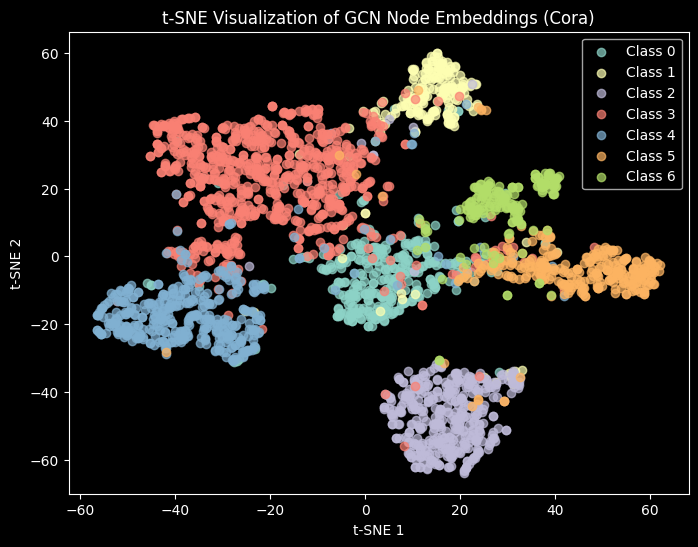

In [ ]:
model.eval()
with torch.no_grad():
    embeddings = model(data_Cora.x, data_Cora.edge_index) 

embeddings_np = embeddings.numpy()

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(8, 6))
num_classes = dataset.num_classes
for i in range(num_classes):
    idx = (data_Cora.y == i).numpy()
    plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=f"Class {i}", alpha=0.7)

plt.legend()
plt.title("t-SNE Visualization of GCN Node Embeddings (Cora)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


In [35]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads=8):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels*heads, num_classes, heads=1)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


In [36]:
model = GAT(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
model

GAT(
  (conv1): GATConv(1433, 16, heads=8)
  (conv2): GATConv(128, 7, heads=1)
)

In [37]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight : 300})'''))

for epoch in range(1, num_epochs):

    loss = train(data_Cora, data_Cora.train_mask)
    if epoch%10 == 0:
        train_acc = test(data_Cora, data_Cora.train_mask)
        print(f'Epoch : {epoch:03d}, Train: {train_acc:.4f}')
accuracy_list.append(['PyG', 'DataCora', train_acc])

<IPython.core.display.Javascript object>

Epoch : 010, Train: 0.3493
Epoch : 020, Train: 0.7831
Epoch : 030, Train: 0.9048
Epoch : 040, Train: 0.9280
Epoch : 050, Train: 0.9536
Epoch : 060, Train: 0.9694
Epoch : 070, Train: 0.9801
Epoch : 080, Train: 0.9884
Epoch : 090, Train: 0.9934
Epoch : 100, Train: 0.9950
Epoch : 110, Train: 0.9983
Epoch : 120, Train: 0.9983
Epoch : 130, Train: 0.9983
Epoch : 140, Train: 0.9983
Epoch : 150, Train: 0.9983
Epoch : 160, Train: 0.9983
Epoch : 170, Train: 0.9983
Epoch : 180, Train: 0.9983
Epoch : 190, Train: 0.9983


In [38]:
test(data_Cora, data_Cora.test_mask)

0.819

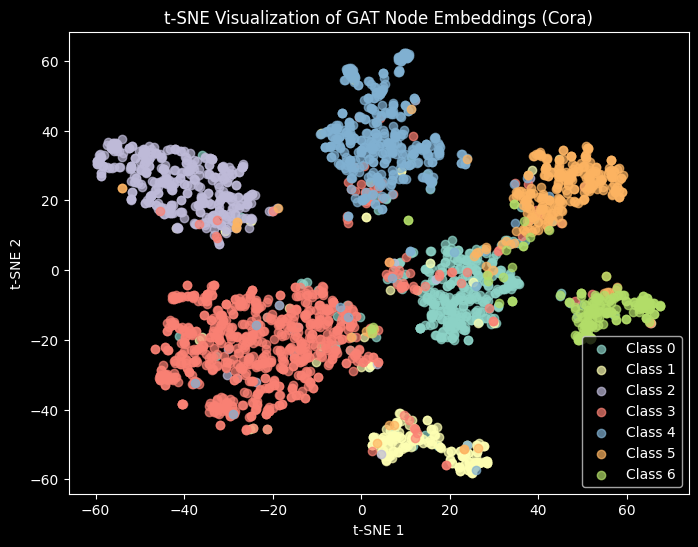

In [40]:
model.eval()
with torch.no_grad():
    embeddings = model(data_Cora.x, data_Cora.edge_index) 

embeddings_np = embeddings.numpy()

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(8, 6))
num_classes = dataset.num_classes
for i in range(num_classes):
    idx = (data_Cora.y == i).numpy()
    plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=f"Class {i}", alpha=0.7)

plt.legend()
plt.title("t-SNE Visualization of GAT Node Embeddings (Cora)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


In [41]:
import torch.nn.functional as F

class DeepGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=16, num_layers=2, residual=False):
        super().__init__()
        self.num_layers = num_layers
        self.residual = residual
        
        # Input layer
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(num_features, hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers-2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            
        # Output layer
        self.convs.append(GCNConv(hidden_channels, num_classes))
    
    def forward(self, x, edge_index):
        h = x
        for i, conv in enumerate(self.convs[:-1]):
            h_next = conv(h, edge_index).relu()
            if self.residual and h.shape == h_next.shape:
                h_next = h_next + h  # residual connection
            h = h_next
        h = self.convs[-1](h, edge_index)  # output layer
        return h


In [42]:
def train(model, data, mask, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        acc = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
    return acc


In [49]:
import numpy as np
from torch_geometric.data import Data
import torch
import torch.nn.functional as F

def compute_accuracy_per_depth(data: Data, hidden_layers_list, residual=False, num_epochs=200, lr=0.01):
    train_accs, test_accs = [], []

    for depth in hidden_layers_list:
        print(f"Running depth {depth}, residual={residual}")
        model = DeepGCN(num_features=num_features,
                        num_classes=num_classes,
                        hidden_channels=16,
                        num_layers=depth,
                        residual=residual)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        
        for epoch in range(1, num_epochs+1):
            train(model, data, data.train_mask, optimizer, criterion)
        
        train_acc = test(model, data, data.train_mask)
        test_acc = test(model, data, data.test_mask)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    return train_accs, test_accs


In [50]:
hidden_layers_list = [2, 4, 8, 16]

train_acc_res, test_acc_res = compute_accuracy_per_depth(data_Cora, hidden_layers_list, residual=True)
train_acc_nores, test_acc_nores = compute_accuracy_per_depth(data_Cora, hidden_layers_list, residual=False)


Running depth 2, residual=True
Running depth 4, residual=True
Running depth 8, residual=True
Running depth 16, residual=True
Running depth 2, residual=False
Running depth 4, residual=False
Running depth 8, residual=False
Running depth 16, residual=False


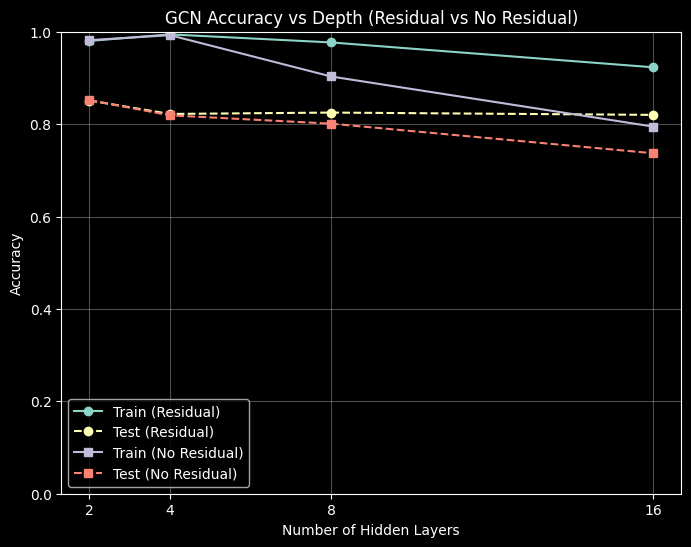

In [51]:
plt.figure(figsize=(8,6))

plt.plot(hidden_layers_list, train_acc_res, marker='o', label='Train (Residual)')
plt.plot(hidden_layers_list, test_acc_res, marker='o', linestyle='--', label='Test (Residual)')

plt.plot(hidden_layers_list, train_acc_nores, marker='s', label='Train (No Residual)')
plt.plot(hidden_layers_list, test_acc_nores, marker='s', linestyle='--', label='Test (No Residual)')

plt.xlabel("Number of Hidden Layers")
plt.ylabel("Accuracy")
plt.title("GCN Accuracy vs Depth (Residual vs No Residual)")
plt.xticks(hidden_layers_list)
plt.ylim(0,1)
plt.grid(alpha=0.3)
plt.legend()
plt.show()
